<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/CA_LabelingData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow

This colab aims in labeling the CA data for super spread week, safe week and improvement week as per the 'number of cases' increasing or decreasing every week.

Idea: 
* compute 7 -day moving average
* 14 days data compare with next 14 days rolling window
* split the % as buckets 
* label the data as per bucket

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture
from datetime import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')


In [4]:
!ls  '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'

CA_combined_Sep09.csv
CA_Covid-19.csv
CA-CovidAug22.csv
CA_socialDistancingInertiaData_Sep09.csv
Maryland_University_SocialDistancing_Data
mask_rule.csv
mask_rule_data.csv
Newyork_combinedAug22.csv
Newyork_combined.csv
NY_Covid-19.csv
NY-CovidAug21.csv
NY-CovidAug22.csv
NY_labeledData_Aug23.csv
NY_labeledData_Aug27.csv
NY_sd_inertia_labeledData_Aug26.csv
NY_sd_inertia_labeledData_Aug27.csv
NY_socialDistancingInertiaDataAug25.csv
queens_all_combined.csv
queens_all_filtered.csv
Queens_county.csv
Social_Distancing_Inertia_County.csv


# 1.1 Loading CA Combined data

In [5]:
NY_combined_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/CA_combined_Sep09.csv',low_memory=False)
NY_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0
1,2020-03-02,6001,Alameda County,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0
2,2020-03-03,6001,Alameda County,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1
3,2020-03-04,6001,Alameda County,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0
4,2020-03-05,6001,Alameda County,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0


## Computing rolling average

In [6]:
NY_combined_data.iloc[:,15]

0        0
1        0
2        1
3        0
4        0
        ..
9191     0
9192    28
9193    35
9194     0
9195     8
Name: New cases, Length: 9196, dtype: int64

In [7]:
df = pd.DataFrame(columns=['Date','fips_x','County Name','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','mask_rule_active','mask_wearing_percent','New cases','rolling_avg_new_cases'])


In [8]:
NY_counties = NY_combined_data['County Name'].unique()

for county in NY_counties:
  county_data = NY_combined_data[NY_combined_data['County Name'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases'] = county_data.iloc[:,15].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,NaN
1,2020-03-02,6001,Alameda County,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0,NaN
2,2020-03-03,6001,Alameda County,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1,NaN
3,2020-03-04,6001,Alameda County,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0,NaN
4,2020-03-05,6001,Alameda County,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0,NaN


In [9]:
print(df.shape)
NY_combined_data.shape

(9196, 17)


(9196, 16)

In [10]:
NY_combined_data = df.copy()
NY_combined_data

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.000,0,NaN
1,2020-03-02,6001,Alameda County,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.000,0,NaN
2,2020-03-03,6001,Alameda County,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.000,1,NaN
3,2020-03-04,6001,Alameda County,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.000,0,NaN
4,2020-03-05,6001,Alameda County,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.000,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9191,2020-08-17,6115,Yuba County,-11.0,12.0,0.0,-11.0,-34.0,7.0,64.29,4.100,43,124.506204,1,0.669,0,16.000000
9192,2020-08-18,6115,Yuba County,-13.0,9.0,0.0,-21.0,-32.0,8.0,54.39,4.944,52,124.506204,1,0.669,28,17.142857
9193,2020-08-19,6115,Yuba County,-13.0,5.0,0.0,-22.0,-33.0,8.0,61.72,4.090,43,124.506204,1,0.669,35,20.428571
9194,2020-08-20,6115,Yuba County,-13.0,11.0,0.0,-19.0,-33.0,8.0,59.48,4.096,43,124.506204,1,0.669,0,19.000000


In [11]:
NY_combined_data[NY_combined_data['Date'] == '2020-08-01']

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
151,2020-08-01,6001,Alameda County,-44.0,-13.0,28.0,-49.0,-19.0,9.0,9.45,1.041,16,2261.547725,1,0.795,345,164.857143
323,2020-08-01,6005,Amador County,-9.0,12.0,0.0,0.0,-15.0,0.0,123.25,2.433,18,66.857277,1,0.655,10,7.714286
495,2020-08-01,6007,Butte County,-21.0,2.0,39.0,0.0,-15.0,3.0,55.33,2.452,53,133.939112,1,0.626,0,26.142857
667,2020-08-01,6009,Calaveras County,-31.0,0.0,0.0,0.0,-10.0,0.0,154.27,5.737,33,45.004461,1,0.562,0,3.714286
839,2020-08-01,6011,Colusa County,-14.0,0.0,0.0,-18.0,-5.0,0.0,138.38,10.870,75,18.724636,1,0.700,0,8.571429
1011,2020-08-01,6013,Contra Costa County,-34.0,-3.0,24.0,-33.0,-21.0,7.0,25.51,1.790,23,1611.204850,1,0.806,136,148.000000
1183,2020-08-01,6015,Del Norte County,32.0,48.0,0.0,0.0,-3.0,0.0,388.59,2.082,92,27.635959,1,0.547,0,0.142857
1355,2020-08-01,6017,El Dorado County,-13.0,9.0,161.0,3.0,-17.0,4.0,174.95,4.362,44,112.913671,1,0.675,0,17.714286
1527,2020-08-01,6019,Fresno County,-24.0,0.0,30.0,-16.0,-15.0,4.0,47.48,1.743,26,167.690949,1,0.741,0,267.857143
1699,2020-08-01,6021,Glenn County,-13.0,5.0,0.0,26.0,-15.0,0.0,135.39,5.116,35,21.608889,1,0.594,0,8.571429


In [12]:
NY_combined_data.head(8)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,NaN
1,2020-03-02,6001,Alameda County,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0,NaN
2,2020-03-03,6001,Alameda County,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1,NaN
3,2020-03-04,6001,Alameda County,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0,NaN
4,2020-03-05,6001,Alameda County,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0,NaN
5,2020-03-06,6001,Alameda County,1.0,5.0,-1.0,-7.0,0.0,2.0,25.77,6.704,106,2261.547725,0,0.0,0,NaN
6,2020-03-07,6001,Alameda County,-6.0,4.0,-23.0,-14.0,1.0,3.0,12.82,4.869,77,2261.547725,0,0.0,1,0.285714
7,2020-03-08,6001,Alameda County,-2.0,4.0,14.0,-8.0,1.0,1.0,-14.65,3.408,54,2261.547725,0,0.0,0,0.285714


## clean data - fill NA 

In [13]:
NY_combined_data = NY_combined_data.fillna(0)
NY_combined_data.head(8)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.000000
1,2020-03-02,6001,Alameda County,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0,0.000000
2,2020-03-03,6001,Alameda County,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1,0.000000
3,2020-03-04,6001,Alameda County,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0,0.000000
4,2020-03-05,6001,Alameda County,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0,0.000000
5,2020-03-06,6001,Alameda County,1.0,5.0,-1.0,-7.0,0.0,2.0,25.77,6.704,106,2261.547725,0,0.0,0,0.000000
6,2020-03-07,6001,Alameda County,-6.0,4.0,-23.0,-14.0,1.0,3.0,12.82,4.869,77,2261.547725,0,0.0,1,0.285714
7,2020-03-08,6001,Alameda County,-2.0,4.0,14.0,-8.0,1.0,1.0,-14.65,3.408,54,2261.547725,0,0.0,0,0.285714


In [14]:
NY_combined_data['County Name'].unique()

array(['Alameda County', 'Amador County', 'Butte County',
       'Calaveras County', 'Colusa County', 'Contra Costa County',
       'Del Norte County', 'El Dorado County', 'Fresno County',
       'Glenn County', 'Humboldt County', 'Imperial County',
       'Inyo County', 'Kern County', 'Kings County', 'Lake County',
       'Lassen County', 'Los Angeles County', 'Madera County',
       'Marin County', 'Mariposa County', 'Mendocino County',
       'Merced County', 'Mono County', 'Monterey County', 'Napa County',
       'Nevada County', 'Orange County', 'Placer County', 'Plumas County',
       'Riverside County', 'Sacramento County', 'San Benito County',
       'San Bernardino County', 'San Diego County',
       'San Francisco County', 'San Joaquin County',
       'San Luis Obispo County', 'San Mateo County',
       'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
       'Shasta County', 'Siskiyou County', 'Solano County',
       'Sonoma County', 'Stanislaus County', 'Su

## verifying Rolling average with visualizations

In [15]:
albany_county = NY_combined_data[NY_combined_data['County Name'] == 'Los Angeles County']
print(albany_county.shape)
albany_county.head()

(172, 17)


,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
2924,2020-03-01,6037,Los Angeles County,4.0,3.0,-5.0,-3.0,1.0,0.0,-4.36,3.996,60,2473.978284,0,0.0,0,0.0
2925,2020-03-02,6037,Los Angeles County,5.0,5.0,8.0,1.0,4.0,-1.0,7.51,6.502,98,2473.978284,0,0.0,0,0.0
2926,2020-03-03,6037,Los Angeles County,8.0,7.0,32.0,2.0,3.0,-1.0,17.24,6.591,99,2473.978284,0,0.0,0,0.0
2927,2020-03-04,6037,Los Angeles County,4.0,6.0,9.0,-1.0,2.0,0.0,13.82,6.595,100,2473.978284,0,0.0,6,0.0
2928,2020-03-05,6037,Los Angeles County,4.0,7.0,9.0,0.0,2.0,0.0,22.17,7.008,106,2473.978284,0,0.0,4,0.0


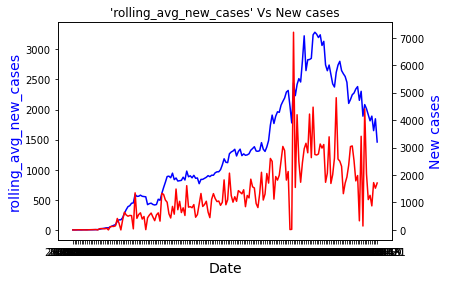

In [16]:
fig,ax = plt.subplots()
# make a plot
ax.plot(albany_county.Date, albany_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(albany_county.Date, albany_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

In [17]:
suffolk_county = NY_combined_data[NY_combined_data['County Name'] == 'Santa Clara County']

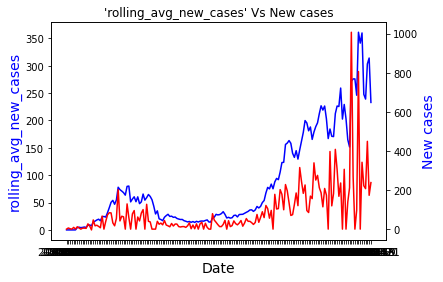

In [18]:
fig,ax = plt.subplots()
# make a plot
ax.plot(suffolk_county.Date, suffolk_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(suffolk_county.Date, suffolk_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

## Rolling window to compare every 2 weeks with next 2 weeks

In [19]:
NY_combined_data = NY_combined_data.sort_values(by=['Date'])
NY_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0
5240,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0
5412,2020-03-01,6069,San Benito County,2.0,-1.0,-7.0,0.0,0.0,0.0,10.40,3.876,33,45.227585,0,0.0,0,0.0
5584,2020-03-01,6071,San Bernardino County,5.0,-2.0,-22.0,2.0,-1.0,0.0,10.34,4.508,57,108.694796,0,0.0,0,0.0
5756,2020-03-01,6073,San Diego County,2.0,-1.0,-20.0,-4.0,2.0,0.0,-4.99,4.555,59,793.587741,0,0.0,0,0.0


In [20]:
NY_combined_data[NY_combined_data['fips_x'] == 6001]

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.000,0,0.000000
1,2020-03-02,6001,Alameda County,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.000,0,0.000000
2,2020-03-03,6001,Alameda County,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.000,1,0.000000
3,2020-03-04,6001,Alameda County,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.000,0,0.000000
4,2020-03-05,6001,Alameda County,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,2020-08-17,6001,Alameda County,-37.0,-18.0,11.0,-62.0,-55.0,20.0,2.63,0.946,15,2261.547725,1,0.795,150,213.142857
168,2020-08-18,6001,Alameda County,-37.0,-13.0,22.0,-62.0,-54.0,20.0,6.70,1.614,25,2261.547725,1,0.795,314,258.000000
169,2020-08-19,6001,Alameda County,-38.0,-15.0,2.0,-63.0,-54.0,21.0,13.19,0.803,12,2261.547725,1,0.795,399,246.285714
170,2020-08-20,6001,Alameda County,-37.0,-13.0,6.0,-63.0,-55.0,21.0,11.24,1.295,20,2261.547725,1,0.795,348,233.714286


In [21]:
minDate = NY_combined_data['Date'].min()
print(minDate)

dateList = NY_combined_data['Date'].unique()

2020-03-01


In [22]:
import datetime

#dt_object = datetime.fromtimestamp(date)
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

day = datetime.datetime.strptime(minDate, '%Y-%m-%d').weekday()
if day == 6:
  day =0
elif day < 6:
  day += 1

print(day)

0


In [23]:
index = 0
count = 0
lst = []
while index < len(dateList):
  row = []
  j = 14 - day;
  # print(index,j)
  # print(dateList[index:index+j])
  weekRange = dateList[index:index+j]
  #print(weekRange)
  index = index+j 
  day = 0
  count +=1
  row.append(count)
  row.append(weekRange.min())
  row.append(weekRange.max())
  print(row)
  lst.append(row)
  


[1, '2020-03-01', '2020-03-14']
[2, '2020-03-15', '2020-03-28']
[3, '2020-03-29', '2020-04-11']
[4, '2020-04-12', '2020-04-26']
[5, '2020-04-27', '2020-05-10']
[6, '2020-05-11', '2020-05-24']
[7, '2020-05-25', '2020-06-08']
[8, '2020-06-09', '2020-06-22']
[9, '2020-06-23', '2020-07-06']
[10, '2020-07-07', '2020-07-20']
[11, '2020-07-21', '2020-08-03']
[12, '2020-08-04', '2020-08-17']
[13, '2020-08-18', '2020-08-21']


In [24]:
week_df = pd.DataFrame(lst,index=None,columns=['WeekNumber','startDate','endDate'])
week_df.head(2)

,WeekNumber,startDate,endDate
0,1,2020-03-01,2020-03-14
1,2,2020-03-15,2020-03-28


## Slice data for the week dataframe

In [25]:

average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in week_df.iterrows():
    startDate, endDate = row['startDate'], row['endDate']
    df_index = (NY_combined_data['Date'] >= startDate) & (NY_combined_data['Date'] <= endDate)
    df_weekData =  NY_combined_data.loc[df_index]
    df_base = (
      df_weekData
      .pipe(lambda x: x.assign(gains_pctg=x["rolling_avg_new_cases"]))
      .groupby(['County Name','fips_x'])
      .agg({"gains_pctg": "mean"})
      .reset_index()
      .rename(columns={"gains_pctg": "average_per_week"})
    )
    df_base['startDate'] = startDate
    df_base['endDate'] = endDate
  
    #print(startDate,endDate,df_base['average_per_week'])
    average_newCases_df = average_newCases_df.append(df_base)


In [26]:
average_newCases_df.shape

(701, 5)

In [27]:
average_newCases_df[average_newCases_df['fips_x'] == 6001]

,County Name,fips_x,average_per_week,startDate,endDate
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14
0,Alameda County,6001,10.632653,2020-03-15,2020-03-28
0,Alameda County,6001,37.051020,2020-03-29,2020-04-11
0,Alameda County,6001,45.193878,2020-04-12,2020-04-26
0,Alameda County,6001,41.561224,2020-04-27,2020-05-10
0,Alameda County,6001,51.530612,2020-05-11,2020-05-24
0,Alameda County,6001,69.744898,2020-05-25,2020-06-08
0,Alameda County,6001,73.724490,2020-06-09,2020-06-22
0,Alameda County,6001,122.785714,2020-06-23,2020-07-06
0,Alameda County,6001,169.846939,2020-07-07,2020-07-20


## Verifying average per week data Eg., Los Angeles County

In [28]:
albany_county[(albany_county['Date'] >= '2020-03-01') & (albany_county['Date'] <= '2020-03-14') ]['rolling_avg_new_cases']



2924    0.000000
2925    0.000000
2926    0.000000
2927    0.000000
2928    0.000000
2929    0.000000
2930    1.857143
2931    1.857143
2932    1.857143
2933    2.714286
2934    2.857143
2935    3.000000
2936    3.857143
2937    5.571429
Name: rolling_avg_new_cases, dtype: float64

In [29]:
average_newCases_df.head(10)

,County Name,fips_x,average_per_week,startDate,endDate
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14
1,Amador County,6005,0.000000,2020-03-01,2020-03-14
2,Butte County,6007,0.000000,2020-03-01,2020-03-14
3,Calaveras County,6009,0.081633,2020-03-01,2020-03-14
4,Colusa County,6011,0.000000,2020-03-01,2020-03-14
5,Contra Costa County,6013,1.051020,2020-03-01,2020-03-14
6,Del Norte County,6015,0.000000,2020-03-01,2020-03-14
7,El Dorado County,6017,0.000000,2020-03-01,2020-03-14
8,Fresno County,6019,0.091837,2020-03-01,2020-03-14
9,Glenn County,6021,0.000000,2020-03-01,2020-03-14


## Finding the % growth or reduction in 'new cases' on every 2 week average

In [30]:
average_newCases_df_ = average_newCases_df.copy()

In [31]:
albany_avg_newCases = average_newCases_df[average_newCases_df['County Name'] == 'Los Angeles County']
albany_avg_newCases

,County Name,fips_x,average_per_week,startDate,endDate
17,Los Angeles County,6037,1.683673,2020-03-01,2020-03-14
17,Los Angeles County,6037,65.061224,2020-03-15,2020-03-28
17,Los Angeles County,6037,460.224490,2020-03-29,2020-04-11
17,Los Angeles County,6037,593.397959,2020-04-12,2020-04-26
17,Los Angeles County,6037,870.357143,2020-04-27,2020-05-10
17,Los Angeles County,6037,894.602041,2020-05-11,2020-05-24
17,Los Angeles County,6037,1237.336735,2020-05-25,2020-06-08
17,Los Angeles County,6037,1371.520408,2020-06-09,2020-06-22
17,Los Angeles County,6037,2071.102041,2020-06-23,2020-07-06
17,Los Angeles County,6037,2912.918367,2020-07-07,2020-07-20


In [32]:
# average_newCases_df = average_newCases_df.sort_values(by=['startDate','endDate'])

# print(average_newCases_df.shape)
# temp = average_newCases_df.groupby(['County Name','fips_x','startDate','endDate'])['average_per_week']
# temp = temp.sum().diff().reset_index()
# print("-------------")
# print(temp)
# print(temp.shape)

# average_newCases_df2 = average_newCases_df.merge(temp,on=['County Name','fips_x','startDate','endDate'])
# print(average_newCases_df2.shape)

In [33]:
average_newCases_df.head()

,County Name,fips_x,average_per_week,startDate,endDate
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14
1,Amador County,6005,0.000000,2020-03-01,2020-03-14
2,Butte County,6007,0.000000,2020-03-01,2020-03-14
3,Calaveras County,6009,0.081633,2020-03-01,2020-03-14
4,Colusa County,6011,0.000000,2020-03-01,2020-03-14


In [34]:
# average_newCases_df = average_newCases_df.sort_values(by=['startDate','endDate'])

# print(average_newCases_df.shape)
# temp = average_newCases_df.groupby(['County Name','fips_x','startDate','endDate'])['average_per_week']
# temp = temp.sum().diff().reset_index()
# print("-------------")
# print(temp)
# print(temp.shape)

# average_newCases_df2 = average_newCases_df.merge(temp,on=['County Name','fips_x','startDate','endDate'])
# print(average_newCases_df2.shape)

In [35]:
average_newCases_df2 = average_newCases_df.copy()

average_newCases_df2 = average_newCases_df2.reset_index(drop=True)
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14
1,Amador County,6005,0.000000,2020-03-01,2020-03-14
2,Butte County,6007,0.000000,2020-03-01,2020-03-14
3,Calaveras County,6009,0.081633,2020-03-01,2020-03-14
4,Colusa County,6011,0.000000,2020-03-01,2020-03-14


In [36]:
average_newCases_df2['diff_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x'])['average_per_week'].diff().fillna(0)

print(average_newCases_df2.shape)
average_newCases_df2.head()


(701, 6)


,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14,0.0
1,Amador County,6005,0.000000,2020-03-01,2020-03-14,0.0
2,Butte County,6007,0.000000,2020-03-01,2020-03-14,0.0
3,Calaveras County,6009,0.081633,2020-03-01,2020-03-14,0.0
4,Colusa County,6011,0.000000,2020-03-01,2020-03-14,0.0


In [37]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Los Angeles County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
17,Los Angeles County,6037,1.683673,2020-03-01,2020-03-14,0.000000
71,Los Angeles County,6037,65.061224,2020-03-15,2020-03-28,63.377551
125,Los Angeles County,6037,460.224490,2020-03-29,2020-04-11,395.163265
178,Los Angeles County,6037,593.397959,2020-04-12,2020-04-26,133.173469
232,Los Angeles County,6037,870.357143,2020-04-27,2020-05-10,276.959184
286,Los Angeles County,6037,894.602041,2020-05-11,2020-05-24,24.244898
340,Los Angeles County,6037,1237.336735,2020-05-25,2020-06-08,342.734694
394,Los Angeles County,6037,1371.520408,2020-06-09,2020-06-22,134.183673
448,Los Angeles County,6037,2071.102041,2020-06-23,2020-07-06,699.581633
502,Los Angeles County,6037,2912.918367,2020-07-07,2020-07-20,841.816327


In [38]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Alameda County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14,0.000000
54,Alameda County,6001,10.632653,2020-03-15,2020-03-28,10.316327
108,Alameda County,6001,37.051020,2020-03-29,2020-04-11,26.418367
161,Alameda County,6001,45.193878,2020-04-12,2020-04-26,8.142857
215,Alameda County,6001,41.561224,2020-04-27,2020-05-10,-3.632653
269,Alameda County,6001,51.530612,2020-05-11,2020-05-24,9.969388
323,Alameda County,6001,69.744898,2020-05-25,2020-06-08,18.214286
377,Alameda County,6001,73.724490,2020-06-09,2020-06-22,3.979592
431,Alameda County,6001,122.785714,2020-06-23,2020-07-06,49.061224
485,Alameda County,6001,169.846939,2020-07-07,2020-07-20,47.061224


In [39]:
average_newCases_df2[average_newCases_df2['fips_x'] == 6001].head(5)

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14,0.000000
54,Alameda County,6001,10.632653,2020-03-15,2020-03-28,10.316327
108,Alameda County,6001,37.051020,2020-03-29,2020-04-11,26.418367
161,Alameda County,6001,45.193878,2020-04-12,2020-04-26,8.142857
215,Alameda County,6001,41.561224,2020-04-27,2020-05-10,-3.632653


In [40]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Santa Clara County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
40,Santa Clara County,6085,3.224490,2020-03-01,2020-03-14,0.000000
94,Santa Clara County,6085,27.683673,2020-03-15,2020-03-28,24.459184
147,Santa Clara County,6085,64.071429,2020-03-29,2020-04-11,36.387755
201,Santa Clara County,6085,42.714286,2020-04-12,2020-04-26,-21.357143
255,Santa Clara County,6085,20.908163,2020-04-27,2020-05-10,-21.806122
309,Santa Clara County,6085,16.489796,2020-05-11,2020-05-24,-4.418367
363,Santa Clara County,6085,26.387755,2020-05-25,2020-06-08,9.897959
417,Santa Clara County,6085,37.612245,2020-06-09,2020-06-22,11.224490
471,Santa Clara County,6085,105.969388,2020-06-23,2020-07-06,68.357143
525,Santa Clara County,6085,164.336735,2020-07-07,2020-07-20,58.367347


In [41]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14,0.0
1,Amador County,6005,0.000000,2020-03-01,2020-03-14,0.0
2,Butte County,6007,0.000000,2020-03-01,2020-03-14,0.0
3,Calaveras County,6009,0.081633,2020-03-01,2020-03-14,0.0
4,Colusa County,6011,0.000000,2020-03-01,2020-03-14,0.0


In [42]:
average_newCases_df2 = average_newCases_df2.fillna(0)

In [43]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14,0.0
1,Amador County,6005,0.000000,2020-03-01,2020-03-14,0.0
2,Butte County,6007,0.000000,2020-03-01,2020-03-14,0.0
3,Calaveras County,6009,0.081633,2020-03-01,2020-03-14,0.0
4,Colusa County,6011,0.000000,2020-03-01,2020-03-14,0.0


In [44]:
#not working
#average_newCases_df2['pct_change_newcases'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x','startDate','endDate']).average_per_week_y.pct_change()

Shifting average_per_week_x	 column value for formula. Means previous row's value will be come to the current row.

In [45]:
average_newCases_df2['shift_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x'])['average_per_week'].shift()

In [46]:
average_newCases_df2.groupby(by=['County Name', 'fips_x','startDate','endDate']).sum()

average_per_week  ...  shift_avg_x
County Name    fips_x startDate  endDate                       ...             
Alameda County 6001   2020-03-01 2020-03-14          0.316327  ...     0.000000
                      2020-03-15 2020-03-28         10.632653  ...     0.316327
                      2020-03-29 2020-04-11         37.051020  ...    10.632653
                      2020-04-12 2020-04-26         45.193878  ...    37.051020
                      2020-04-27 2020-05-10         41.561224  ...    45.193878
...                                                       ...  ...          ...
Yuba County    6115   2020-06-23 2020-07-06          4.387755  ...     0.632653
                      2020-07-07 2020-07-20         10.377551  ...     4.387755
                      2020-07-21 2020-08-03         15.040816  ...    10.377551
                      2020-08-04 2020-08-17         18.632653  ...    15.040816
                      2020-08-18 2020-08-21         17.321429  ...    18.632653

[701 rows x 3 columns]

In [47]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Los Angeles County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x
17,Los Angeles County,6037,1.683673,2020-03-01,2020-03-14,0.000000,NaN
71,Los Angeles County,6037,65.061224,2020-03-15,2020-03-28,63.377551,1.683673
125,Los Angeles County,6037,460.224490,2020-03-29,2020-04-11,395.163265,65.061224
178,Los Angeles County,6037,593.397959,2020-04-12,2020-04-26,133.173469,460.224490
232,Los Angeles County,6037,870.357143,2020-04-27,2020-05-10,276.959184,593.397959
286,Los Angeles County,6037,894.602041,2020-05-11,2020-05-24,24.244898,870.357143
340,Los Angeles County,6037,1237.336735,2020-05-25,2020-06-08,342.734694,894.602041
394,Los Angeles County,6037,1371.520408,2020-06-09,2020-06-22,134.183673,1237.336735
448,Los Angeles County,6037,2071.102041,2020-06-23,2020-07-06,699.581633,1371.520408
502,Los Angeles County,6037,2912.918367,2020-07-07,2020-07-20,841.816327,2071.102041


In [48]:
average_newCases_df2['percent_newcases'] = average_newCases_df2.apply(lambda x: (x.diff_avg_x) / x.shift_avg_x if x.shift_avg_x > 0.0 else 0 , axis=1)


average_newCases_df2.tail()


,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
696,Tulare County,6107,152.428571,2020-08-18,2020-08-21,-36.540816,188.969388,-0.193369
697,Tuolumne County,6109,1.214286,2020-08-18,2020-08-21,-0.336735,1.551020,-0.217105
698,Ventura County,6111,98.500000,2020-08-18,2020-08-21,-27.255102,125.755102,-0.216732
699,Yolo County,6113,31.750000,2020-08-18,2020-08-21,0.178571,31.571429,0.005656
700,Yuba County,6115,17.321429,2020-08-18,2020-08-21,-1.311224,18.632653,-0.070372


In [49]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Los Angeles County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
17,Los Angeles County,6037,1.683673,2020-03-01,2020-03-14,0.000000,NaN,0.000000
71,Los Angeles County,6037,65.061224,2020-03-15,2020-03-28,63.377551,1.683673,37.642424
125,Los Angeles County,6037,460.224490,2020-03-29,2020-04-11,395.163265,65.061224,6.073714
178,Los Angeles County,6037,593.397959,2020-04-12,2020-04-26,133.173469,460.224490,0.289366
232,Los Angeles County,6037,870.357143,2020-04-27,2020-05-10,276.959184,593.397959,0.466734
286,Los Angeles County,6037,894.602041,2020-05-11,2020-05-24,24.244898,870.357143,0.027856
340,Los Angeles County,6037,1237.336735,2020-05-25,2020-06-08,342.734694,894.602041,0.383114
394,Los Angeles County,6037,1371.520408,2020-06-09,2020-06-22,134.183673,1237.336735,0.108446
448,Los Angeles County,6037,2071.102041,2020-06-23,2020-07-06,699.581633,1371.520408,0.510077
502,Los Angeles County,6037,2912.918367,2020-07-07,2020-07-20,841.816327,2071.102041,0.406458


# 1.2 Labeling data as per % change

In [50]:
average_newCases_df2.describe()

,fips_x,average_per_week,diff_avg_x,shift_avg_x,percent_newcases
count,701.000000,701.000000,701.000000,647.000000,701.000000
mean,6057.724679,72.344621,10.945282,66.505312,1.635755
std,32.987094,237.898878,72.155794,233.986807,6.209127
min,6001.000000,-1.892857,-537.673469,-0.357143,-2.500000
25%,6029.000000,0.530612,-0.030612,0.423469,-0.019417
50%,6059.000000,6.020408,0.581633,5.204082,0.190476
75%,6085.000000,42.867347,7.857143,37.923469,0.960000
max,6115.000000,2912.918367,841.816327,2912.918367,95.421053


In [51]:
albany_county = average_newCases_df2[average_newCases_df2['County Name'] == 'Los Angeles County']

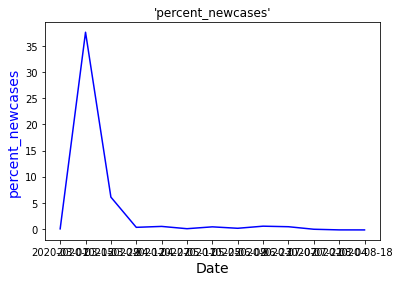

In [52]:
fig,ax = plt.subplots()
# make a plot
ax.plot(albany_county.startDate, albany_county['percent_newcases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("percent_newcases",color="blue",fontsize=14)
# ax2=ax.twinx()
# make a plot with different y-axis using second axis object
# ax2.plot(albany_county.startDate, albany_county["percent_newcases"],color="red")
# ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'percent_newcases'")

plt.show()

In [53]:
data = average_newCases_df2['percent_newcases'].to_list()

print(data)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.61290322580645, 0.0, 0.0, 0.12499999999999997, 0.0, 5.446601941747573, 0.0, 0.0, 11.333333333333332, 0.0, 0.0, 10.333333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 37.64242424242425, 4.571428571428573, 26.38461538461538, 0.0, 0.0, 0.0, 0.0, 0.0, 12.000000000000002, 0.0, 44.24242424242424, 2.96969696969697, 0.0, 13.166666666666666, 8.391891891891893, 44.0, 0.0, 95.42105263157892, 10.387387387387385, 25.812500000000004, 0.0, 12.266666666666664, 0.0, 7.585443037974684, 5.90909090909091, 0.8333333333333334, 0.0, 4.333333333333332, 18.0, 9.124999999999998, 0.0, 0.0, 29.000000000000004, 0.0, 33.99999999999999, 7.8571428571428585, 0.0, 2.4846449136276387, 0.16666666666666677, 1.6249999999999998, 1.5555555555555556, 15.9999999999999

In [54]:
average_newCases_df3 = average_newCases_df2.copy().reset_index(drop=True)

## Jenks Natural breaks 

In [55]:
!pip install jenkspy


In [56]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=3)
print(breaks)

[-2.5000000000000004, 13.882352941176471, 44.24242424242424, 95.42105263157892]


In [57]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=8)
print(breaks)

[-2.5000000000000004, 0.8571428571428573, 3.5725982532751104, 9.124999999999998, 21.000000000000004, 33.99999999999999, 44.24242424242424, 60.11538461538463, 95.42105263157892]


In [58]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=4)
print(breaks)

[-2.5000000000000004, 5.226851851851851, 21.000000000000004, 44.24242424242424, 95.42105263157892]


### Labeling criteria

We have applied "jenks Natural breaks' to label the county data as per 'percent change in cases'

From the natural break algorithm, we have splited the data as follows 

* -1.136 to 3.642 is **label 1** (least chance of spreading) 

* 3.642 to 13.625 is **label 2** (Below threshold but chances to reach super spread level)

* 13.625 to 410.181818 is **label 3** (Super spread week)

In [59]:
# for 4 labels
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread','SuperSpread2'])

In [60]:
# for 8 labels
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=8)
print(breaks)

average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread1','SuperSpread2','SuperSpread3','SuperSpread4','SuperSpread5','SuperSpread6'])

[-2.5000000000000004, 0.8571428571428573, 3.5725982532751104, 9.124999999999998, 21.000000000000004, 33.99999999999999, 44.24242424242424, 60.11538461538463, 95.42105263157892]


In [61]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['County Name'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['County Name'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']['County Name'].count())

print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['County Name'].count())

Number of records in LessSpread: 514
Number of records in Spread: 119
Number of records in SuperSpread: 0
Number of records in SuperSpread: 18


In [62]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['County Name'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['County Name'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread1']['County Name'].count())
print('Number of records in SuperSpread2:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['County Name'].count())


print('Number of records in SuperSpread3:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread3']['County Name'].count())

print('Number of records in SuperSpread4:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread4']['County Name'].count())

print('Number of records in SuperSpread5:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread5']['County Name'].count())

print('Number of records in SuperSpread6:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread6']['County Name'].count())




Number of records in LessSpread: 514
Number of records in Spread: 119
Number of records in SuperSpread: 38
Number of records in SuperSpread2: 18
Number of records in SuperSpread3: 6
Number of records in SuperSpread4: 3
Number of records in SuperSpread5: 1
Number of records in SuperSpread6: 1


In [63]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,labels
0,Alameda County,6001,0.316327,2020-03-01,2020-03-14,0.0,NaN,0.0,LessSpread
1,Amador County,6005,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,LessSpread
2,Butte County,6007,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,LessSpread
3,Calaveras County,6009,0.081633,2020-03-01,2020-03-14,0.0,NaN,0.0,LessSpread
4,Colusa County,6011,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,LessSpread


# 1.3 Labeling data for CA combined

In [64]:
NY_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0
5240,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0
5412,2020-03-01,6069,San Benito County,2.0,-1.0,-7.0,0.0,0.0,0.0,10.40,3.876,33,45.227585,0,0.0,0,0.0
5584,2020-03-01,6071,San Bernardino County,5.0,-2.0,-22.0,2.0,-1.0,0.0,10.34,4.508,57,108.694796,0,0.0,0,0.0
5756,2020-03-01,6073,San Diego County,2.0,-1.0,-20.0,-4.0,2.0,0.0,-4.99,4.555,59,793.587741,0,0.0,0,0.0


In [65]:
NY_combined_data_ = NY_combined_data.copy()



In [66]:
NY_combined_data = NY_combined_data_.copy().reset_index(drop=True)

In [67]:
#average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in (average_newCases_df2.iterrows()):
    startDate, endDate = row['startDate'], row['endDate']
    fips = row['fips_x']
    #print(startDate,endDate,fips)
    df_index = (NY_combined_data['fips_x'] == row['fips_x']) & (NY_combined_data['Date'] >= startDate) & (NY_combined_data['Date'] <= endDate)
    df_weekData =  NY_combined_data.loc[df_index]
    #print(df_weekData)
    NY_combined_data.loc[df_index,'label'] = row['labels']




In [68]:
NY_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,LessSpread
1,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0,LessSpread
2,2020-03-01,6069,San Benito County,2.0,-1.0,-7.0,0.0,0.0,0.0,10.40,3.876,33,45.227585,0,0.0,0,0.0,LessSpread
3,2020-03-01,6071,San Bernardino County,5.0,-2.0,-22.0,2.0,-1.0,0.0,10.34,4.508,57,108.694796,0,0.0,0,0.0,LessSpread
4,2020-03-01,6073,San Diego County,2.0,-1.0,-20.0,-4.0,2.0,0.0,-4.99,4.555,59,793.587741,0,0.0,0,0.0,LessSpread


In [69]:
NY_combined_data[NY_combined_data['label'] == 'SuperSpread2'].sort_values(by=['fips_x','Date']).count()

Date                     252
fips_x                   252
County Name              252
retail and recreation    252
grocery and pharmacy     252
parks                    252
transit stations         252
workplaces               252
residential              252
driving                  252
m50                      252
m50_index                252
population_density       252
mask_rule_active         252
mask_wearing_percent     252
New cases                252
rolling_avg_new_cases    252
label                    252
dtype: int64

In [70]:
NY_combined_data.shape

(9196, 18)

In [71]:
NY_combined_data['label'] = NY_combined_data['label'].apply(lambda x: x if x != 'SuperSpread2' else 'SuperSpread')


### Save Labeled data for CA Combined Data

In [73]:
from datetime import datetime

filename = 'CA_labeledData_'+datetime.now().strftime("%b%d") #%Y%m%d
print(filename)


NY_combined_data.to_csv(filename,index=False)

CA_labeledData_Sep09


In [ ]:
average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']

## Kernal Density Estimation

In [ ]:
%matplotlib inline

from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

a = array(data).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(a)
s = linspace(0,50)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

In [ ]:


from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

In [ ]:
lower_range = s[mi][0]
upper_range = s[mi][1]

lower_range

In [ ]:
print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


[-1.1363636363636362, 39.5, 213.91325695581014, 410.1818181818182]

Minima: [19.3877551  33.67346939]
Maxima: [24.48979592 39.79591837]*italicized text*

In [ ]:
plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
     s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
     s[mi[1]:], e[mi[1]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')

print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


## Labeling Data with Kernal density results

In [ ]:
average_newCases_df3.head()

In [ ]:
print(lower_range, upper_range)

In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range  else 'SuperSpread')


In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range else ('Spread' if (x >= lower_range and x <= upper_range) else 'SuperSpread'))



#converter = lambda x : x*2 if x < 10 else (x*3 if x < 20 else x)



In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'lessSpread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'Spread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'SuperSpread'].count()

In [ ]:
average_newCases_df3.head()

# 2.1 Loading NY - Social Distancing Inertia Maryland Data

In [ ]:
NY_combined_sd_inertia_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/CA_socialDistancingInertiaData_Sep09.csv',low_memory=False)
NY_combined_sd_inertia_data.head()

In [ ]:
NY_combined_sd_inertia_data.FIPS.unique()

## Computing rolling average

In [ ]:
NY_combined_sd_inertia_data.columns

In [ ]:
#new case column nume = 5
NY_combined_sd_inertia_data.iloc[:,5]

removing comuns: 
'Confirmed', 'Deaths', 'New deaths','#days: decreasing ILI cases', '#days: decreasing COVID cases', 'New cases/1000 people', 'Imported COVID cases' ,'COVID death rate',  'Active cases/1000 people',

In [ ]:
df = pd.DataFrame(columns=['Date', 'Province_State', 'FIPS',  'New cases',
        'mask_rule_active', 'CTFIPS', 'CTNAME', 'STFIPS',
       'Social distancing index', '% staying home', 'Trips/person',
       '% out-of-county trips', '% out-of-state trips', 'Miles/person',
       'Work trips/person', 'Non-work trips/person', 'New COVID cases',
       'Population', '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
        'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation rate',
        '% hospital bed utilization',
       'Testing capacity', 'Tests done/1000 people', '% ICU utilization',
       'Ventilator shortage'])


In [ ]:
NY_counties = NY_combined_sd_inertia_data['CTNAME'].unique()

for county in NY_counties:
  county_data = NY_combined_sd_inertia_data[NY_combined_sd_inertia_data['CTNAME'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases'] = county_data.iloc[:,5].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

In [ ]:
print(df.shape)
NY_combined_sd_inertia_data.shape

In [ ]:
NY_combined_sd_inertia_data = df.copy()
NY_combined_sd_inertia_data

In [ ]:
NY_combined_sd_inertia_data.head(3)

## clean data - fill NA 

In [ ]:
NY_combined_sd_inertia_data = NY_combined_sd_inertia_data.fillna(0)
NY_combined_sd_inertia_data.head(4)

In [ ]:
NY_combined_sd_inertia_data['CTNAME'].unique()

## verifying Rolling average with visualizations - Los Angeles County

In [ ]:
albany_county = NY_combined_sd_inertia_data[NY_combined_sd_inertia_data['CTNAME'] == 'Los Angeles County']
print(albany_county.shape)
albany_county.head()

In [ ]:
fig,ax = plt.subplots()
# make a plot
ax.plot(albany_county.Date, albany_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(albany_county.Date, albany_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

In [ ]:
suffolk_county = NY_combined_sd_inertia_data[NY_combined_sd_inertia_data['CTNAME'] == 'Alameda County']

In [ ]:
fig,ax = plt.subplots()
# make a plot
ax.plot(suffolk_county.Date, suffolk_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(suffolk_county.Date, suffolk_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

## Rolling window to compare every 2 weeks with next 2 weeks

In [ ]:
NY_combined_sd_inertia_data = NY_combined_sd_inertia_data.sort_values(by=['Date'])
NY_combined_sd_inertia_data.head()

In [ ]:
NY_combined_sd_inertia_data[NY_combined_sd_inertia_data['FIPS'] == 6001]

In [ ]:
minDate = NY_combined_sd_inertia_data['Date'].min()
print(minDate)

dateList = NY_combined_sd_inertia_data['Date'].unique()

In [ ]:
import datetime

#dt_object = datetime.fromtimestamp(date)
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

day = datetime.datetime.strptime(minDate, '%Y-%m-%d').weekday()
if day == 6:
  day =0
elif day < 6:
  day += 1

print(day)

In [ ]:
index = 0
count = 0
lst = []
while index < len(dateList):
  row = []
  j = 14 - day;
  # print(index,j)
  # print(dateList[index:index+j])
  weekRange = dateList[index:index+j]
  #print(weekRange)
  index = index+j 
  day = 0
  count +=1
  row.append(count)
  row.append(weekRange.min())
  row.append(weekRange.max())
  print(row)
  lst.append(row)
  


In [ ]:
week_df = pd.DataFrame(lst,index=None,columns=['WeekNumber','startDate','endDate'])
week_df.head(2)

## Slice data for the week dataframe

In [ ]:

average_newCases_df = pd.DataFrame(columns=['CTNAME',  'FIPS',  'average_per_week','startDate','endDate'])

for index, row in week_df.iterrows():
    startDate, endDate = row['startDate'], row['endDate']
    df_index = (NY_combined_sd_inertia_data['Date'] >= startDate) & (NY_combined_sd_inertia_data['Date'] <= endDate)
    df_weekData =  NY_combined_sd_inertia_data.loc[df_index]
    df_base = (
      df_weekData
      .pipe(lambda x: x.assign(gains_pctg=x["rolling_avg_new_cases"]))
      .groupby(['CTNAME','FIPS'])
      .agg({"gains_pctg": "mean"})
      .reset_index()
      .rename(columns={"gains_pctg": "average_per_week"})
    )
    df_base['startDate'] = startDate
    df_base['endDate'] = endDate
  
    #print(startDate,endDate,df_base['average_per_week'])
    average_newCases_df = average_newCases_df.append(df_base)


In [ ]:
average_newCases_df.shape

In [ ]:
average_newCases_df[average_newCases_df['FIPS'] == 6001]

## Verifying average per week data Eg., alameda County

In [ ]:
albany_county[(albany_county['Date'] >= '2020-03-01') & (albany_county['Date'] <= '2020-03-14') ]['rolling_avg_new_cases']



In [ ]:
average_newCases_df.head(10)

## Finding the % growth or reduction in 'new cases' on every 2 week average

In [ ]:
average_newCases_df_ = average_newCases_df.copy()

In [ ]:
albany_avg_newCases = average_newCases_df[average_newCases_df['CTNAME'] == 'Alameda County']
albany_avg_newCases

In [ ]:
average_newCases_df.head()

In [ ]:
average_newCases_df2 = average_newCases_df.copy()

average_newCases_df2 = average_newCases_df2.reset_index(drop=True)
average_newCases_df2.head()

In [ ]:
average_newCases_df2['diff_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['CTNAME', 'FIPS'])['average_per_week'].diff().fillna(0)

print(average_newCases_df2.shape)
average_newCases_df2.head()


In [ ]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Santa Clara County']

In [ ]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Alameda County']

In [ ]:
average_newCases_df2[average_newCases_df2['FIPS'] == 6071].head(5)

In [ ]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Santa Clara County']

In [ ]:
average_newCases_df2.head()

In [ ]:
average_newCases_df2 = average_newCases_df2.fillna(0)

In [ ]:
average_newCases_df2.head()

Shifting average_per_week_x	 column value for formula. Means previous row's value will be come to the current row.

In [ ]:
average_newCases_df2['shift_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['CTNAME', 'FIPS'])['average_per_week'].shift()

In [ ]:
average_newCases_df2.groupby(by=['CTNAME', 'FIPS','startDate','endDate']).sum()

In [ ]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Santa Clara County']

In [ ]:
average_newCases_df2['percent_newcases'] = average_newCases_df2.apply(lambda x: (x.diff_avg_x) / x.shift_avg_x if x.shift_avg_x > 0.0 else 0 , axis=1)


average_newCases_df2.tail()


In [ ]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Santa Clara County']

# 2.2 Labeling data as per % change

In [ ]:
average_newCases_df2.describe()

In [ ]:
albany_county = average_newCases_df2[average_newCases_df2['CTNAME'] == 'Los Angeles County']

In [ ]:
fig,ax = plt.subplots()
# make a plot
ax.plot(albany_county.startDate, albany_county['percent_newcases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("percent_newcases",color="blue",fontsize=14)
# ax2=ax.twinx()
# make a plot with different y-axis using second axis object
# ax2.plot(albany_county.startDate, albany_county["percent_newcases"],color="red")
# ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'percent_newcases'")

plt.show()

In [ ]:
data = average_newCases_df2['percent_newcases'].to_list()

print(data)


In [ ]:
average_newCases_df3 = average_newCases_df2.copy().reset_index(drop=True)

## Jenks Natural breaks 

In [ ]:
!pip install jenkspy


In [ ]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=3)
print(breaks)

### Labeling criteria

We have applied "jenks Natural breaks' to label the county data as per 'percent change in cases'

From the natural break algorithm, we have splited the data as follows 

* -1.136 to 3.642 is **label 1** (least chance of spreading) 

* 3.642 to 13.625 is **label 2** (Below threshold but chances to reach super spread level)

* 13.625 to 410.181818 is **label 3** (Super spread week)

4 class labeling

In [ ]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=4)
print(breaks)

In [ ]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread','SuperSpread2'])

In [ ]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['CTNAME'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['CTNAME'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']['CTNAME'].count())

print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['CTNAME'].count())

8 class labeling

In [ ]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=8)
print(breaks)

In [ ]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread1','SuperSpread2','SuperSpread3','SuperSpread4','SuperSpread5','SuperSpread6'])

In [ ]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['CTNAME'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['CTNAME'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread1']['CTNAME'].count())
print('Number of records in SuperSpread2:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['CTNAME'].count())
print('Number of records in SuperSpread3:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread3']['CTNAME'].count())
print('Number of records in SuperSpread4:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread4']['CTNAME'].count())
print('Number of records in SuperSpread5:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread5']['CTNAME'].count())
print('Number of records in SuperSpread6:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread6']['CTNAME'].count())

In [ ]:
average_newCases_df2.head()

# 2.3 Labeling data for CA -Maryland Social Distancing Inertia combined

In [ ]:
NY_combined_sd_inertia_data.head(2)

In [ ]:
NY_combined_sd_inertia_data_ = NY_combined_sd_inertia_data.copy()

In [ ]:
NY_combined_sd_inertia_data = NY_combined_sd_inertia_data_.copy().reset_index(drop=True)

In [ ]:
#average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in (average_newCases_df2.iterrows()):
    startDate, endDate = row['startDate'], row['endDate']
    fips = row['FIPS']
    #print(startDate,endDate,fips)
    df_index = (NY_combined_sd_inertia_data['FIPS'] == row['FIPS']) & (NY_combined_sd_inertia_data['Date'] >= startDate) & (NY_combined_sd_inertia_data['Date'] <= endDate)
    df_weekData =  NY_combined_sd_inertia_data.loc[df_index]
    #print(df_weekData)
    NY_combined_sd_inertia_data.loc[df_index,'label'] = row['labels']




In [ ]:
NY_combined_sd_inertia_data.head(5)

In [ ]:
NY_combined_sd_inertia_data[NY_combined_sd_inertia_data['label'] == 'SuperSpread2'].sort_values(by=['FIPS','Date']).count()

In [ ]:
NY_combined_sd_inertia_data.shape

In [ ]:
NY_combined_sd_inertia_data['label'] = NY_combined_sd_inertia_data['label'].apply(lambda x: x if x != 'SuperSpread2' else 'SuperSpread')




### Save CA- Marlyland labeled Data

In [ ]:
from datetime import datetime

filename = 'CA_sd_inertia_labeledData_'+datetime.now().strftime("%b%d") #%Y%m%d
print(filename)
NY_combined_sd_inertia_data.to_csv(filename,index=False)

In [ ]:
average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']

## Kernal Density Estimation

In [ ]:
%matplotlib inline

from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

a = array(data).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(a)
s = linspace(0,50)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

In [ ]:


from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

In [ ]:
lower_range = s[mi][0]
upper_range = s[mi][1]

lower_range

In [ ]:
print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


[-1.1363636363636362, 39.5, 213.91325695581014, 410.1818181818182]

Minima: [19.3877551  33.67346939]
Maxima: [24.48979592 39.79591837]*italicized text*

In [ ]:
plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
     s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
     s[mi[1]:], e[mi[1]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')

print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


## Labeling Data with Kernal density results

In [ ]:
average_newCases_df3.head()

In [ ]:
print(lower_range, upper_range)

In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range  else 'SuperSpread')


In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range else ('Spread' if (x >= lower_range and x <= upper_range) else 'SuperSpread'))



#converter = lambda x : x*2 if x < 10 else (x*3 if x < 20 else x)



In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'lessSpread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'Spread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'SuperSpread'].count()

In [ ]:
average_newCases_df3.head()